# Deploying on a test set
- Use model weights from various models (ResNet and CNN) to test on set of triplets of covers and random different songs
- Try various triplet accuracy metrics

In [6]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import dotenv_values 
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, roc_curve
from transformers import AutoProcessor, AutoModel, ASTModel, AutoFeatureExtractor, AutoModelForAudioClassification, Wav2Vec2Model

import torch.optim as optim
from pydub import AudioSegment
import io


### Extract Embeddings

In [7]:
# Define pretrained resnet from Torch Vision resnet 18
class ResNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=128, dropout_rate=0.5):
        # get resnet super class
        super(ResNetEmbedding, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        # Change structure of first layer to take non RGB images, rest of params same as default
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        # Set the last fully connected to a set dimension "embedding_dim" instead of default 1000
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.resnet(x)
        return F.normalize(x, p=2, dim=1)

In [8]:
# Define our other network
class MusicSimilarityCNN(nn.Module):
    def __init__(self, embedding_dim=128, dropout_rate=0.5):
        super(MusicSimilarityCNN, self).__init__()
        
        # Layers to get to 128 dim embeddings
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) 
        
        # Batch norm for each 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # FCs
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, embedding_dim)
        
    def forward(self, x):
        # Add step to resize test set mel specs
        x = torch.nn.functional.interpolate(x, size=(128, 128))
        # CNN layers with ReLU activation and pooling - input [32, 1, 128,128]
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Conv -> BatchNorm -> Relu -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 128 * 8 * 8) # 128*8*8 = 8192 --> Shape = []
        #x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        
        # Output the embeddings
        x = self.fc2(x)
        return F.normalize(x, p=2, dim=1)  # Normalize embeddings for better similarity comparison


In [9]:
class AudioSpecTransformerModel(torch.nn.Module):
    def __init__(self, pretrained_model_name="MIT/ast-finetuned-audioset-10-10-0.4593", embedding_dim=128, dropout_rate=0.5):
        super(AudioSpecTransformerModel, self).__init__()
        
        self.model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(self.model.config.hidden_size, embedding_dim)

    def forward(self, x):
        outputs = self.model(x).last_hidden_state
        
        # Get [cls] token embedding for classification/summary of embedding
        x = self.fc(outputs[:, 0, :])
        
        return F.normalize(x, p=2, dim=1)

In [10]:
# How to load the model later using just the state dictionary
#model = ResNetEmbedding()  # Make sure this matches the architecture you used
#model.load_state_dict(torch.load('../modeling/resnet_output/resnet18_model_weights.pth', map_location=torch.device('cpu')))

#model = MusicSimilarityCNN()
#model.load_state_dict(torch.load('../modeling/cnn_output/cnn_model_weights.pth', map_location=torch.device('cpu')))

model = AudioSpecTransformerModel()
model.load_state_dict(torch.load('../modeling/transformer_output/audio_spec_checkpoint.pth', map_location=torch.device('cpu')))

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

RuntimeError: Error(s) in loading state_dict for AudioSpecTransformerModel:
	Missing key(s) in state_dict: "model.embeddings.cls_token", "model.embeddings.distillation_token", "model.embeddings.position_embeddings", "model.embeddings.patch_embeddings.projection.weight", "model.embeddings.patch_embeddings.projection.bias", "model.encoder.layer.0.attention.attention.query.weight", "model.encoder.layer.0.attention.attention.query.bias", "model.encoder.layer.0.attention.attention.key.weight", "model.encoder.layer.0.attention.attention.key.bias", "model.encoder.layer.0.attention.attention.value.weight", "model.encoder.layer.0.attention.attention.value.bias", "model.encoder.layer.0.attention.output.dense.weight", "model.encoder.layer.0.attention.output.dense.bias", "model.encoder.layer.0.intermediate.dense.weight", "model.encoder.layer.0.intermediate.dense.bias", "model.encoder.layer.0.output.dense.weight", "model.encoder.layer.0.output.dense.bias", "model.encoder.layer.0.layernorm_before.weight", "model.encoder.layer.0.layernorm_before.bias", "model.encoder.layer.0.layernorm_after.weight", "model.encoder.layer.0.layernorm_after.bias", "model.encoder.layer.1.attention.attention.query.weight", "model.encoder.layer.1.attention.attention.query.bias", "model.encoder.layer.1.attention.attention.key.weight", "model.encoder.layer.1.attention.attention.key.bias", "model.encoder.layer.1.attention.attention.value.weight", "model.encoder.layer.1.attention.attention.value.bias", "model.encoder.layer.1.attention.output.dense.weight", "model.encoder.layer.1.attention.output.dense.bias", "model.encoder.layer.1.intermediate.dense.weight", "model.encoder.layer.1.intermediate.dense.bias", "model.encoder.layer.1.output.dense.weight", "model.encoder.layer.1.output.dense.bias", "model.encoder.layer.1.layernorm_before.weight", "model.encoder.layer.1.layernorm_before.bias", "model.encoder.layer.1.layernorm_after.weight", "model.encoder.layer.1.layernorm_after.bias", "model.encoder.layer.2.attention.attention.query.weight", "model.encoder.layer.2.attention.attention.query.bias", "model.encoder.layer.2.attention.attention.key.weight", "model.encoder.layer.2.attention.attention.key.bias", "model.encoder.layer.2.attention.attention.value.weight", "model.encoder.layer.2.attention.attention.value.bias", "model.encoder.layer.2.attention.output.dense.weight", "model.encoder.layer.2.attention.output.dense.bias", "model.encoder.layer.2.intermediate.dense.weight", "model.encoder.layer.2.intermediate.dense.bias", "model.encoder.layer.2.output.dense.weight", "model.encoder.layer.2.output.dense.bias", "model.encoder.layer.2.layernorm_before.weight", "model.encoder.layer.2.layernorm_before.bias", "model.encoder.layer.2.layernorm_after.weight", "model.encoder.layer.2.layernorm_after.bias", "model.encoder.layer.3.attention.attention.query.weight", "model.encoder.layer.3.attention.attention.query.bias", "model.encoder.layer.3.attention.attention.key.weight", "model.encoder.layer.3.attention.attention.key.bias", "model.encoder.layer.3.attention.attention.value.weight", "model.encoder.layer.3.attention.attention.value.bias", "model.encoder.layer.3.attention.output.dense.weight", "model.encoder.layer.3.attention.output.dense.bias", "model.encoder.layer.3.intermediate.dense.weight", "model.encoder.layer.3.intermediate.dense.bias", "model.encoder.layer.3.output.dense.weight", "model.encoder.layer.3.output.dense.bias", "model.encoder.layer.3.layernorm_before.weight", "model.encoder.layer.3.layernorm_before.bias", "model.encoder.layer.3.layernorm_after.weight", "model.encoder.layer.3.layernorm_after.bias", "model.encoder.layer.4.attention.attention.query.weight", "model.encoder.layer.4.attention.attention.query.bias", "model.encoder.layer.4.attention.attention.key.weight", "model.encoder.layer.4.attention.attention.key.bias", "model.encoder.layer.4.attention.attention.value.weight", "model.encoder.layer.4.attention.attention.value.bias", "model.encoder.layer.4.attention.output.dense.weight", "model.encoder.layer.4.attention.output.dense.bias", "model.encoder.layer.4.intermediate.dense.weight", "model.encoder.layer.4.intermediate.dense.bias", "model.encoder.layer.4.output.dense.weight", "model.encoder.layer.4.output.dense.bias", "model.encoder.layer.4.layernorm_before.weight", "model.encoder.layer.4.layernorm_before.bias", "model.encoder.layer.4.layernorm_after.weight", "model.encoder.layer.4.layernorm_after.bias", "model.encoder.layer.5.attention.attention.query.weight", "model.encoder.layer.5.attention.attention.query.bias", "model.encoder.layer.5.attention.attention.key.weight", "model.encoder.layer.5.attention.attention.key.bias", "model.encoder.layer.5.attention.attention.value.weight", "model.encoder.layer.5.attention.attention.value.bias", "model.encoder.layer.5.attention.output.dense.weight", "model.encoder.layer.5.attention.output.dense.bias", "model.encoder.layer.5.intermediate.dense.weight", "model.encoder.layer.5.intermediate.dense.bias", "model.encoder.layer.5.output.dense.weight", "model.encoder.layer.5.output.dense.bias", "model.encoder.layer.5.layernorm_before.weight", "model.encoder.layer.5.layernorm_before.bias", "model.encoder.layer.5.layernorm_after.weight", "model.encoder.layer.5.layernorm_after.bias", "model.encoder.layer.6.attention.attention.query.weight", "model.encoder.layer.6.attention.attention.query.bias", "model.encoder.layer.6.attention.attention.key.weight", "model.encoder.layer.6.attention.attention.key.bias", "model.encoder.layer.6.attention.attention.value.weight", "model.encoder.layer.6.attention.attention.value.bias", "model.encoder.layer.6.attention.output.dense.weight", "model.encoder.layer.6.attention.output.dense.bias", "model.encoder.layer.6.intermediate.dense.weight", "model.encoder.layer.6.intermediate.dense.bias", "model.encoder.layer.6.output.dense.weight", "model.encoder.layer.6.output.dense.bias", "model.encoder.layer.6.layernorm_before.weight", "model.encoder.layer.6.layernorm_before.bias", "model.encoder.layer.6.layernorm_after.weight", "model.encoder.layer.6.layernorm_after.bias", "model.encoder.layer.7.attention.attention.query.weight", "model.encoder.layer.7.attention.attention.query.bias", "model.encoder.layer.7.attention.attention.key.weight", "model.encoder.layer.7.attention.attention.key.bias", "model.encoder.layer.7.attention.attention.value.weight", "model.encoder.layer.7.attention.attention.value.bias", "model.encoder.layer.7.attention.output.dense.weight", "model.encoder.layer.7.attention.output.dense.bias", "model.encoder.layer.7.intermediate.dense.weight", "model.encoder.layer.7.intermediate.dense.bias", "model.encoder.layer.7.output.dense.weight", "model.encoder.layer.7.output.dense.bias", "model.encoder.layer.7.layernorm_before.weight", "model.encoder.layer.7.layernorm_before.bias", "model.encoder.layer.7.layernorm_after.weight", "model.encoder.layer.7.layernorm_after.bias", "model.encoder.layer.8.attention.attention.query.weight", "model.encoder.layer.8.attention.attention.query.bias", "model.encoder.layer.8.attention.attention.key.weight", "model.encoder.layer.8.attention.attention.key.bias", "model.encoder.layer.8.attention.attention.value.weight", "model.encoder.layer.8.attention.attention.value.bias", "model.encoder.layer.8.attention.output.dense.weight", "model.encoder.layer.8.attention.output.dense.bias", "model.encoder.layer.8.intermediate.dense.weight", "model.encoder.layer.8.intermediate.dense.bias", "model.encoder.layer.8.output.dense.weight", "model.encoder.layer.8.output.dense.bias", "model.encoder.layer.8.layernorm_before.weight", "model.encoder.layer.8.layernorm_before.bias", "model.encoder.layer.8.layernorm_after.weight", "model.encoder.layer.8.layernorm_after.bias", "model.encoder.layer.9.attention.attention.query.weight", "model.encoder.layer.9.attention.attention.query.bias", "model.encoder.layer.9.attention.attention.key.weight", "model.encoder.layer.9.attention.attention.key.bias", "model.encoder.layer.9.attention.attention.value.weight", "model.encoder.layer.9.attention.attention.value.bias", "model.encoder.layer.9.attention.output.dense.weight", "model.encoder.layer.9.attention.output.dense.bias", "model.encoder.layer.9.intermediate.dense.weight", "model.encoder.layer.9.intermediate.dense.bias", "model.encoder.layer.9.output.dense.weight", "model.encoder.layer.9.output.dense.bias", "model.encoder.layer.9.layernorm_before.weight", "model.encoder.layer.9.layernorm_before.bias", "model.encoder.layer.9.layernorm_after.weight", "model.encoder.layer.9.layernorm_after.bias", "model.encoder.layer.10.attention.attention.query.weight", "model.encoder.layer.10.attention.attention.query.bias", "model.encoder.layer.10.attention.attention.key.weight", "model.encoder.layer.10.attention.attention.key.bias", "model.encoder.layer.10.attention.attention.value.weight", "model.encoder.layer.10.attention.attention.value.bias", "model.encoder.layer.10.attention.output.dense.weight", "model.encoder.layer.10.attention.output.dense.bias", "model.encoder.layer.10.intermediate.dense.weight", "model.encoder.layer.10.intermediate.dense.bias", "model.encoder.layer.10.output.dense.weight", "model.encoder.layer.10.output.dense.bias", "model.encoder.layer.10.layernorm_before.weight", "model.encoder.layer.10.layernorm_before.bias", "model.encoder.layer.10.layernorm_after.weight", "model.encoder.layer.10.layernorm_after.bias", "model.encoder.layer.11.attention.attention.query.weight", "model.encoder.layer.11.attention.attention.query.bias", "model.encoder.layer.11.attention.attention.key.weight", "model.encoder.layer.11.attention.attention.key.bias", "model.encoder.layer.11.attention.attention.value.weight", "model.encoder.layer.11.attention.attention.value.bias", "model.encoder.layer.11.attention.output.dense.weight", "model.encoder.layer.11.attention.output.dense.bias", "model.encoder.layer.11.intermediate.dense.weight", "model.encoder.layer.11.intermediate.dense.bias", "model.encoder.layer.11.output.dense.weight", "model.encoder.layer.11.output.dense.bias", "model.encoder.layer.11.layernorm_before.weight", "model.encoder.layer.11.layernorm_before.bias", "model.encoder.layer.11.layernorm_after.weight", "model.encoder.layer.11.layernorm_after.bias", "model.layernorm.weight", "model.layernorm.bias", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "model_state_dict", "optimizer_state_dict", "epoch". 

In [ ]:
def compute_distance(model, row, use_model=True):
    song_1 = row['song_1']
    song_2 = row['song_2']
    
    # Assuming the input for deployment is already a mel spec y values
    mel_tensor_1 = torch.tensor(song_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    mel_tensor_2 = torch.tensor(song_2, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Get with model
    if use_model:
        # Get the embedding from the model. No need to normalize, since forward pass does that
        with torch.no_grad():
            embedding_1 = model(mel_tensor_1)
            embedding_2 = model(mel_tensor_2)

    else:
        # Flatten to get rid of dimensions, then unqueeze to make 2D with batch dimension 
        no_model_embedding_1 = F.normalize(mel_tensor_1.flatten().unsqueeze(0), p=2, dim=1)
        no_model_embedding_2 = F.normalize(mel_tensor_2.flatten().unsqueeze(0), p=2, dim=1)

    euclidean_distance = torch.dist(embedding_1, embedding_2).item()
    #cosine_similarity = F.cosine_similarity(embedding_1, embedding_2).item()
    return euclidean_distance

def get_label(row, threshold=0.5):
    if row['euclidean_distance'] > threshold:
        return 1
    else:
        return 0

In [ ]:
# Load dataframe we made for deployment
deploy_df = pd.read_pickle('../data/paired_songs_spectrograms_test.pkl')
deploy_df.head(2)

,song_title_1,artist_1,album_1,song_1,song_title_2,artist_2,album_2,song_2,label
0,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-49.7658, -50.9627, -44.81154, -38.146698, -...",Claudette,everly_brothers,The_Fabulous_Style_of,"[[-26.068644, -23.991093, -23.518074, -26.1214...",1
1,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-49.7658, -50.9627, -44.81154, -38.146698, -...",12-Day_Tripper,/Users/reggiebain/erdos/song-similarity-erdos/...,1,"[[-39.67006, -36.35625, -30.621237, -25.635677...",0


In [ ]:
tqdm.pandas(desc=f"Computing Distances...")
deploy_df['euclidean_distance'] = deploy_df.progress_apply(lambda row: compute_distance(model, row), axis=1)

Computing Distances...: 100%|██████████| 154/154 [00:05<00:00, 27.98it/s]


In [ ]:
# Compare means of means based on label
print(f"Mean Distance of Covers: {deploy_df[deploy_df.label == 1].euclidean_distance.mean()}")
print(f"Mean Distance of NOT Covers: {deploy_df[deploy_df.label == 0].euclidean_distance.mean()}")
#print(f"Mean Sim of Covers: {deploy_df[deploy_df.label == 1].cosine_similarity.mean()}")
#print(f"Mean Sim of NOT Covers: {deploy_df[deploy_df.label == 0].cosine_similarity.mean()}")

Mean Distance of Covers: 0.6915950473252829
Mean Distance of NOT Covers: 0.7203660433168535


In [ ]:
tqdm.pandas(desc=f"Getting Labels using mean threshold...")
deploy_df['deploy_label'] = deploy_df.apply(lambda row: get_label(row, threshold=deploy_df['euclidean_distance'].mean()), axis=1) 

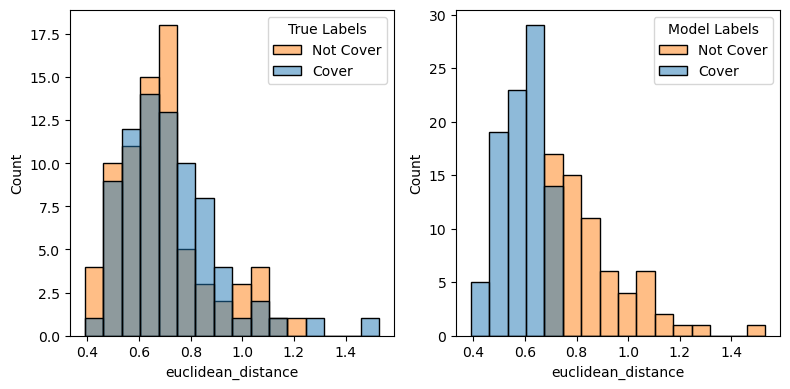

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns.histplot(data=deploy_df, x='euclidean_distance', hue='label', ax=axes[0])
sns.histplot(data=deploy_df, x='euclidean_distance', hue='deploy_label', ax=axes[1])
axes[0].legend(title='True Labels', labels=['Not Cover', 'Cover'])
axes[1].legend(title='Model Labels', labels=['Not Cover', 'Cover'])
plt.tight_layout()
plt.savefig('../images/distances_by_label_transformers.png')
plt.show()

In [ ]:
# Calculate accuracy, precision, recall, F1
accuracy = accuracy_score(deploy_df['label'], deploy_df['deploy_label'])
precision = precision_score(deploy_df['label'], deploy_df['deploy_label'])
f1 = f1_score(deploy_df['label'], deploy_df['deploy_label'])
recall = recall_score(deploy_df['label'], deploy_df['deploy_label'])

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f"Recall: {recall}")


Accuracy: 0.4481
Precision: 0.4375
F1 Score: 0.3972
Recall: 0.36363636363636365


### Try Nearest Neighbor Accuracy and other Triplet Validation

In [ ]:
# Load the original test files with triplets
triplet_df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos/data/test_set_covers.pkl')
triplet_df.head(2)

,song_title,artist,album,song,anchors,positives,negatives,neg_song,neg_artist,neg_album
0,Claudette,everly_brothers,The_Fabulous_Style_of,01-Claudette,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-80.0, -80.0, -80.0, -61.775627, -48.010227,...","[[-80.0, -80.0, -80.0, -80.0, -76.417206, -74....",03-Addicted_To_Love,/Users/reggiebain/erdos/song-similarity-erdos/...,Riptide
1,I_Don_t_Want_To_Miss_A_Thing,aerosmith,Armageddon_Original_Soundtrack_,01-I_Don_t_Want_To_Miss_A_Thing,"[[-80.0, -80.0, -80.0, -79.25159, -56.510735, ...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",09-Summertime_Blues,/Users/reggiebain/erdos/song-similarity-erdos/...,Surfin_USA_Surfin_Safari


In [ ]:
# Find if positive or negative sample is closer. 1 if pos closer 0 if not.
def find_closer_neighbor(row):
    anchor, positive, negative = row['anchors'], row['positives'], row['negatives']

    # Assuming the input for deployment is already a mel spec y values
    anchor_tensor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    positive_tensor = torch.tensor(positive, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    negative_tensor = torch.tensor(negative, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        anchor_embedding = model(anchor_tensor)
        positive_embedding = model(positive_tensor)
        negative_embedding = model(negative_tensor)

    anchor_positive_dist = torch.dist(anchor_embedding, positive_embedding).item()
    anchor_negative_dist = torch.dist(anchor_embedding, negative_embedding).item()
    #cosine_similarity = F.cosine_similarity(embedding_1, embedding_2).item()
    
    closer_neighbor = 1 if anchor_positive_dist > anchor_negative_dist else 0
    return closer_neighbor

# Calculate the accuracy given a column
def get_nn_accuracy(df):
    return df['closer_neighbor'].mean()    

# Calculate baseline accuracy by randomly guessing
def get_baseline_nn_accuracy(df):
    random_guesses = np.random.choice([0, 1], size=len(df))
    baseline_accuracy = (df['closer_neighbor'] == random_guesses).mean()
    return baseline_accuracy

def get_pct_improve(nn, baseline):
    return (nn - baseline)/baseline * 100

In [ ]:
tqdm.pandas(desc=f"Calculating triplet inner products...")
triplet_df['closer_neighbor'] = triplet_df.progress_apply(lambda row: find_closer_neighbor(row), axis=1)
nn_accuracy = get_nn_accuracy(triplet_df)
baseline_accuracy = get_baseline_nn_accuracy(triplet_df)
pct_improve = get_pct_improve(nn_accuracy, baseline_accuracy)

Calculating triplet inner products...:   0%|          | 0/77 [00:00<?, ?it/s]

Calculating triplet inner products...: 100%|██████████| 77/77 [00:06<00:00, 12.01it/s]


In [ ]:
print(f"Nearest Neighbor Accuracy: {nn_accuracy*100:.4f}%")
print(f"Baseline Accuracy: {baseline_accuracy*100:.4f}%")
print(f"Model % Improvement: {pct_improve:.4f}%")

Nearest Neighbor Accuracy: 36.3636%
Baseline Accuracy: 40.2597%
Model % Improvement: -9.6774%


### Search Spotify for Track to Analyze

In [ ]:
# Load stuff from .env file
env_vars = dotenv_values('.env')

client_credentials_manager = SpotifyClientCredentials(
    client_id=os.getenv("SPOTIFY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIFY_CLIENT_SECRET"),
)
# Get Spotify api client and apply to df
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# Function to get the preview URL of a song based on artist name and song title
#@retry(wait=wait_exponential(multiplier=1, min=4, max=60), stop=stop_after_attempt(10))
def search_track(artist_name, track_name, sp, rate_limit = 1.0):
    # Search for the track
    result = sp.search(q=f'artist:{artist_name} track:{track_name}', type='track', limit=1)
    if result['tracks']['items']:
        # Return the preview URL if found
        return result['tracks']['items'][0]['preview_url']
    print('Arist/Track not found...')
    return None    

In [ ]:
track1_name = 'Under Pressure'
track1_artist = 'Bowie'
track2_name = 'Rosanna'
track2_artist = 'Toto'
track1 = search_track(track1_artist, track1_name, sp)
track2 = search_track(track1_artist, track1_name, sp)

In [ ]:
artist_name = 'Robin Thicke'
track_name = 'Surfin USA'
#result = sp.search(q=f'artist:{artist_name} track:{track_name}', type='track', limit=1)
result = sp.search(q=f'track:{track_name}', type='track', limit=1)
preview = None
for item in result['tracks']['items']:
    if item['preview_url'] is not None:
        preview = item['preview_url']
        break
preview   
    